In [5]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import tensorflow as tf


In [6]:
DATA_PATH = Path('data')

In [21]:
cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv(str( DATA_PATH / Path('SeoulBikeData.csv'))).drop(['Date', 'Holiday', 'Seasons'], axis = 1)
df.columns = cols

df['functional'] = (df['functional'] == 'Yes').astype(int)
df = df[df['hour'] == 12]
df = df.drop(['hour'], axis=1)

In [22]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


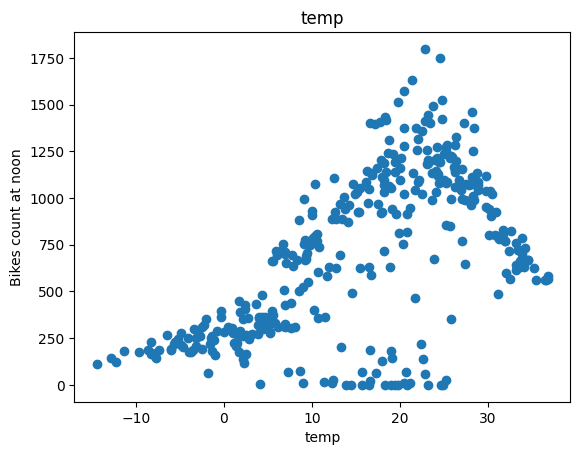

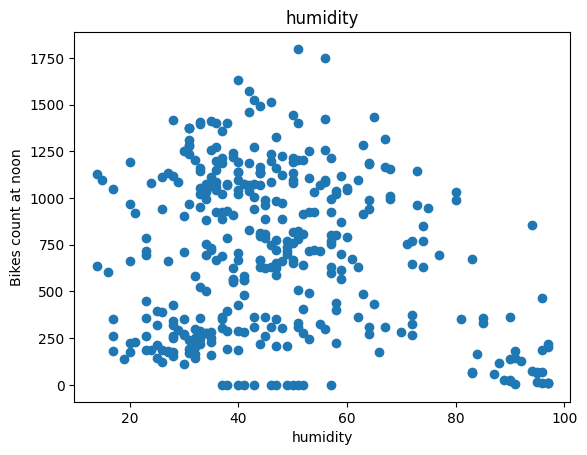

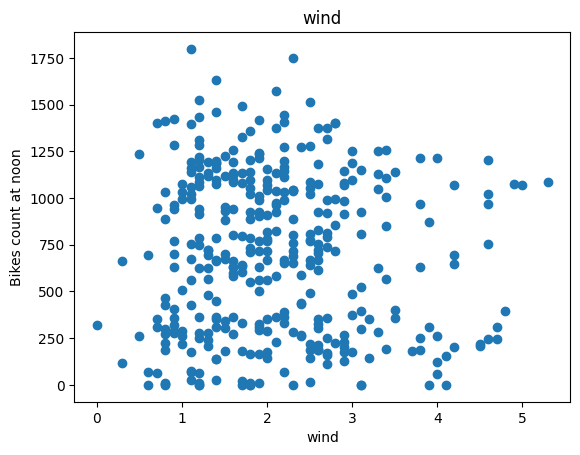

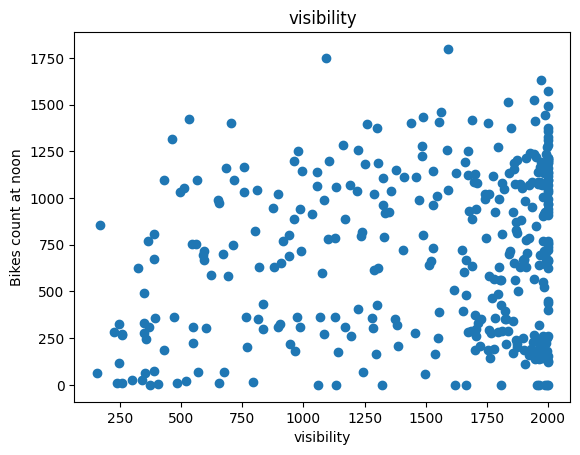

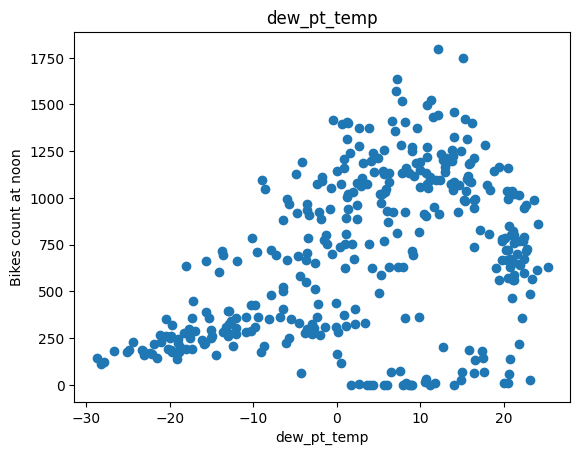

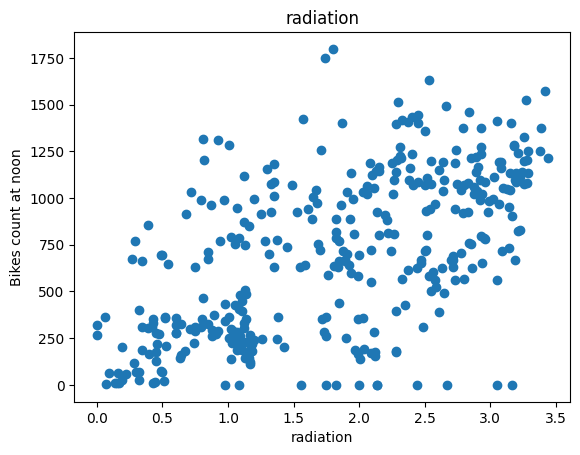

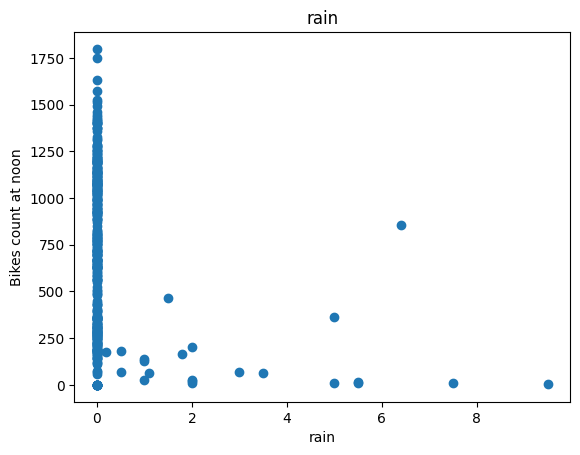

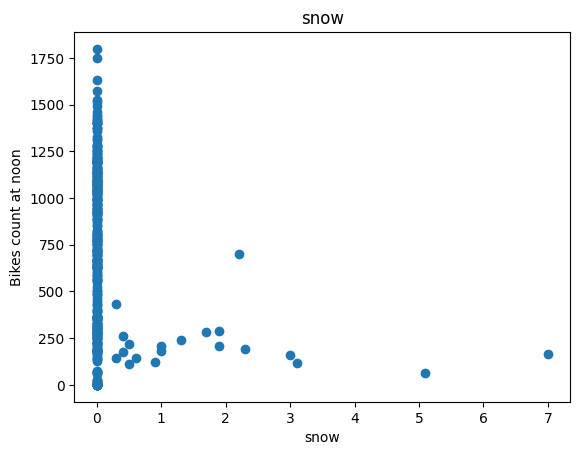

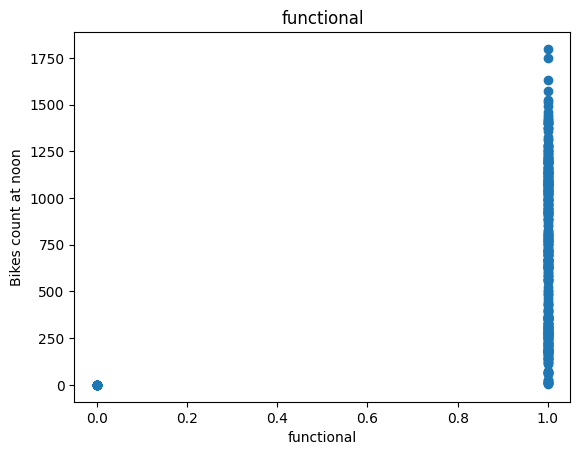

In [23]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel('Bikes count at noon')
    plt.xlabel(label)
    plt.show()
    

In [25]:
df = df.drop(['wind', 'visibility', 'functional'], axis = 1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


### Train/Valid/Test dataset

In [26]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [27]:
def get_xy(df, y_label, x_labels = None):
    df = copy.deepcopy(df)
    if not x_labels:
        X = df[[c for c in df.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = df[x_labels[0]].values.reshape(-1, 1)
        else:
            X = df[x_labels].values

    y = df[y_label].values.reshape(-1, 1)

    data = np.hstack((X, y))

    return data, X, y

In [28]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [29]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [32]:
print(temp_reg.coef_, temp_reg.intercept_)
print(temp_reg.score(X_test_temp, y_test_temp))

[[18.83839767]] [396.67562317]
0.30923082969061244


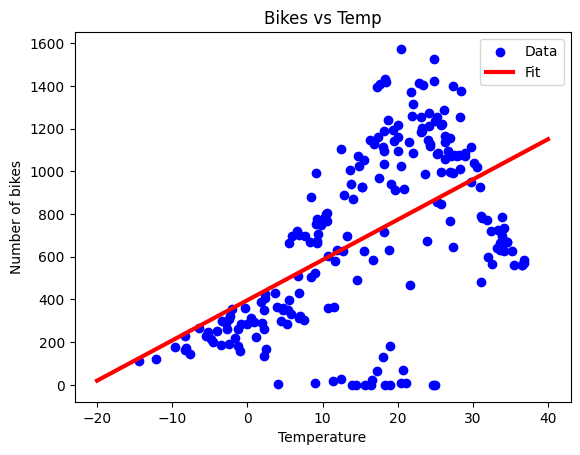

In [33]:
plt.scatter(X_train_temp, y_train_temp, label = 'Data', color = 'blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label = 'Fit', color = 'red', linewidth = 3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temperature')
plt.show()

### Multiple Linear Regression

In [43]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [51]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train, y_train = get_xy(train, 'bike_count', x_labels=['temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain', 'snow'])
_, X_val, y_val = get_xy(val, 'bike_count', x_labels=['temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain', 'snow'])
_, X_test, y_test = get_xy(test, 'bike_count', x_labels=['temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain', 'snow']) 

In [52]:
all_reg = LinearRegression()
all_reg.fit(X_train, y_train)

LinearRegression()

In [53]:
print(all_reg.coef_, all_reg.intercept_)
print(all_reg.score(X_test, y_test))

[[  5.16955195  -6.43064822  12.51761718 121.03820505 -21.90534718
  -30.50816992]] [657.93121685]
0.5108558970582138


### Neural Network

In [134]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

In [135]:
all_normalizer = tf.keras.layers.Normalization(input_shape = (6, ), axis = -1)
all_normalizer.adapt(X_train)

In [136]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [137]:
nn_model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'mean_squared_error',
    metrics = ['accuracy']
)

In [138]:
history = nn_model.fit(
    X_train, y_train, verbose = 0, epochs = 1000, validation_data = (X_val, y_val)
)

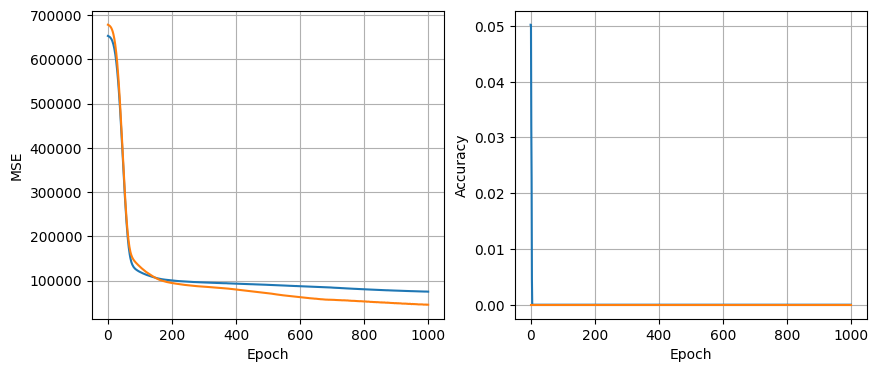

In [139]:
plot_history(history)

In [147]:
# plt.scatter(X_train_temp, y_train_temp, label = 'Data', color = 'blue')
# x = tf.linspace(-20, 40, 100)
# plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label = 'Fit', color = 'red', linewidth = 3)
# plt.legend()
# plt.title('Bikes vs Temp')
# plt.ylabel('Number of bikes')
# plt.xlabel('Temperature')
# plt.show()

In [141]:
# Calculate and compare MSE

def MSE(y_pred, y_test):
    return (np.square(y_pred - y_test)).mean()

In [142]:
y_pred_lr = all_reg.predict(X_test)
y_pred_nn = nn_model.predict(X_test)

3/3 [==============================] - 0s 2ms/step


In [143]:
print(MSE(y_pred_lr, y_test))
print(MSE(y_pred_nn, y_test))

105789.89869931093
78325.74509908697


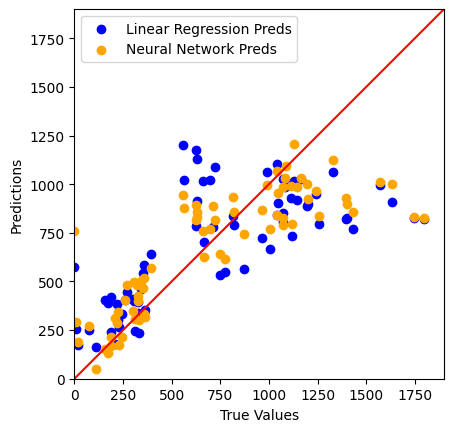

In [144]:
ax = plt.axes(aspect = 'equal')
plt.scatter(y_test, y_pred_lr, color='blue', label = 'Linear Regression Preds')
plt.scatter(y_test, y_pred_nn, color='orange', label = 'Neural Network Preds')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1900]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')